## The problem

Wouldn't it be nice to learn a distribution $P(X)$ of a certain set of images, for simplicity, the images of digits?

You would be able to:

1. Generate new images of digits

2. Say how like an image is from the same distribution (that is, also a digit)

3. inpaint missing image details


It does not seem like a trivial task.

Assume image is $\sqrt{n} \times \sqrt{n}$ pixels, each one black or white; enumerate them from the top left to bottom right $\{ X_1, ..., X_{n}\}$

If we make no assumption about the underlaying distribution, it would take $2^n-1$ parameters to model it, since each pixel in this image can be either black or white with a certain probability $p_i$.


## A solution

A common trick is to use the chain rule
 
$$P(X_1, ..., X_n) = P(X_1) P(X_2|X_1) ... P(X_n|X_1,X_2,...,X_{n-1})$$
 
and then, in a sort of "discriminative manner" to model
 
$$P(X_i|X_1...X_{i-1}) = f_i(X_1, ..., X_{i-1}; \theta_i)$$
 
This would be an example of an *autoregressive* model.

Note that the function $f_i$ and the set of parameters for this function $\theta_i$ might be different for each of those terms.

Some easy example would be to just let

$$P(X_i|X_1...X_{i-1}) = \sigma(\theta_{i1} X_1 + \theta_{i2} X_2 + ... + \theta_{i,i-1} X_{i-1} + \theta_{i0})$$

This is essentially a *separate* logistic regression for each pixel, conditioned on all previous pixels. 

The number of parameters in this model is $\frac{n^2}{2}$.

A bit better seems to have just a dense representation for the previous pixels with a linear linear like 

$$P(X_i|X_1...X_{i-1}) = \sigma(\theta_i^T h(W_{:,1} X_1 + W_{:,2} X_2 + ... + W_{:,i-1} X_{i-1})) = \sigma(\theta_i^T h(W X_{1:i-1}))$$
 
In this case we are still taking a linear combination, but now of a hidden state of fixed size. The number of parameters in this model is $2DH + D + H$, which scales linearly with the number of pixels in the image.

## A demo

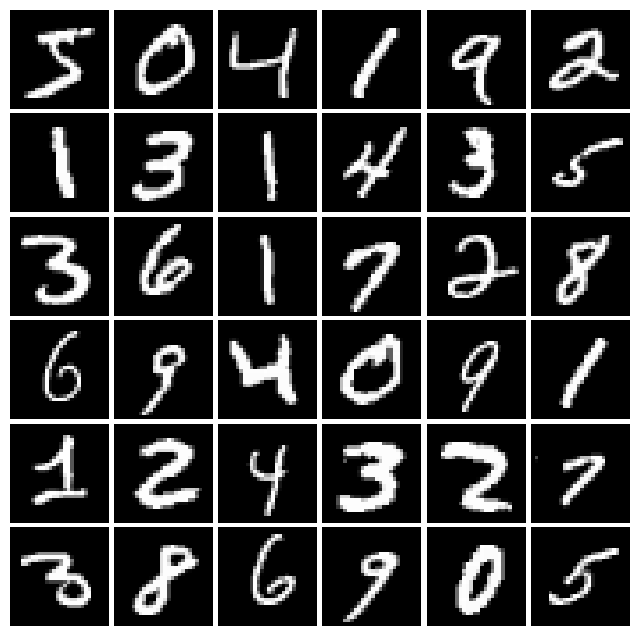

In [43]:
#| echo: false
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

def show_mnist_grid(dataset, num_images=36):
    fig, axes = plt.subplots(6, 6, figsize=(8, 8))
    axes = axes.ravel()
    
    for i in range(num_images):
        image, label = dataset[i]
        image = image.squeeze().numpy()
        image = (image + 1) / 2
        
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

show_mnist_grid(trainset)


In [ ]:
#| echo: false
#| output: false
import json, os
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bin_transform = transforms.ToTensor()
trainset_bin = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=bin_transform)
valset_bin = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=bin_transform)
trainloader_bin = torch.utils.data.DataLoader(trainset_bin, batch_size=128, shuffle=True)
valloader_bin = torch.utils.data.DataLoader(valset_bin, batch_size=256, shuffle=False)


class AutoregressiveLogistic(torch.nn.Module):
    def __init__(self, D: int):
        super().__init__()
        self.D = D
        self.bias = torch.nn.Parameter(torch.zeros(D))
        self.weight = torch.nn.Parameter(torch.zeros(D, D))
        self.register_buffer('mask', torch.tril(torch.ones(D, D), diagonal=-1))

    def logits(self, x: torch.Tensor) -> torch.Tensor:
        return x @ (self.weight * self.mask).t() + self.bias

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.logits(x)
        return -F.binary_cross_entropy_with_logits(logits, x, reduction='none').sum(dim=1)

    def sample(self, num_samples: int) -> torch.Tensor:
        x = torch.zeros(num_samples, self.D, device=self.bias.device)
        for i in range(self.D):
            w_i = self.weight[i] * self.mask[i]
            logits_i = self.bias[i] + x @ w_i
            probs = torch.sigmoid(logits_i)
            x[:, i] = torch.bernoulli(probs)
        return x

class NADE(torch.nn.Module):
    def __init__(self, D: int, H: int):
        super().__init__()
        self.D = D
        self.H = H
        self.a = torch.nn.Parameter(torch.zeros(H))
        self.b = torch.nn.Parameter(torch.zeros(D))
        self.W = torch.nn.Parameter(0.01 * torch.randn(H, D))
        self.V = torch.nn.Parameter(0.01 * torch.randn(D, H))

    def logits(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        s = self.a.unsqueeze(0).expand(B, -1)
        outs = []
        for i in range(self.D):
            h = torch.sigmoid(s)
            li = self.b[i] + (h @ self.V[i].unsqueeze(1)).squeeze(1)
            outs.append(li)
            s = s + x[:, i].unsqueeze(1) * self.W[:, i].unsqueeze(0)
        return torch.stack(outs, dim=1)

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        s = self.a.unsqueeze(0).expand(B, -1)
        total = x.new_zeros(B)
        for i in range(self.D):
            h = torch.sigmoid(s)
            li = self.b[i] + (h @ self.V[i].unsqueeze(1)).squeeze(1)
            total += -F.binary_cross_entropy_with_logits(li, x[:, i], reduction='none')
            s = s + x[:, i].unsqueeze(1) * self.W[:, i].unsqueeze(0)
        return total

    def sample(self, num_samples: int) -> torch.Tensor:
        x = torch.zeros(num_samples, self.D, device=self.a.device)
        s = self.a.unsqueeze(0).expand(num_samples, -1)
        for i in range(self.D):
            h = torch.sigmoid(s)
            li = self.b[i] + (h @ self.V[i].unsqueeze(1)).squeeze(1)
            probs = torch.sigmoid(li)
            xi = torch.bernoulli(probs)
            x[:, i] = xi
            s = s + xi.unsqueeze(1) * self.W[:, i].unsqueeze(0)
        return x

def binarize(batch: torch.Tensor) -> torch.Tensor:
    return (batch > 0.5).float()

def evaluate_nll(model, loader):
    model.eval()
    total, count = 0.0, 0
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device).view(images.size(0), -1)
            images = binarize(images)
            total += (-model.log_prob(images)).sum().item()
            count += images.size(0)
    model.train()
    return total / count

os.makedirs('artifacts', exist_ok=True)

def train_run(model, max_epochs, early_stop=False, patience=5, tag='run'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    best_val = float('inf')
    bad = 0
    logs = []
    step = 0
    for epoch in range(1, max_epochs + 1):
        for images, _ in trainloader_bin:
            images = images.to(device).view(images.size(0), -1)
            images = binarize(images)
            optimizer.zero_grad()
            loss = -model.log_prob(images).mean()
            loss.backward()
            optimizer.step()
            step += 1
            if step % 50 == 0:
                train_nll = loss.item()
                val_nll = evaluate_nll(model, valloader_bin)
                logs.append({'step': step, 'epoch': epoch, 'train_nll': train_nll, 'val_nll': val_nll})
                print({'step': step, 'epoch': epoch, 'train_nll': train_nll, 'val_nll': val_nll})
                if val_nll + 1e-6 < best_val:
                    best_val = val_nll
                    bad = 0
                    torch.save({'model': model.state_dict()}, f'artifacts/{tag}_best.pt')
                else:
                    bad += 1
                if early_stop and bad >= patience:
                    torch.save({'model': model.state_dict()}, f'artifacts/{tag}_earlystop_last.pt')
                    with open(f'artifacts/{tag}_logs.json', 'w') as f:
                        json.dump(logs, f)
                    return logs, f'artifacts/{tag}_best.pt'
        val_nll = evaluate_nll(model, valloader_bin)
        logs.append({'step': step, 'epoch': epoch, 'train_nll': None, 'val_nll': val_nll})
        with open(f'artifacts/{tag}_logs.json', 'w') as f:
            json.dump(logs, f)
    torch.save({'model': model.state_dict()}, f'artifacts/{tag}_last.pt')
    with open(f'artifacts/{tag}_logs.json', 'w') as f:
        json.dump(logs, f)
    return logs, f'artifacts/{tag}_last.pt'


In [ ]:
#| echo: false
#| output: false
D = 28 * 28
# overfit_logs, overfit_ckpt = train_run(AutoregressiveLogistic(D), max_epochs=50, early_stop=False, tag='overfit')
es_logs, es_ckpt = train_run(AutoregressiveLogistic(D), max_epochs=50, early_stop=True, patience=5, tag='early')

In [ ]:
#| echo: false
#| output: false
H = 256
# nade_overfit_logs, nade_overfit_ckpt = train_run(NADE(D, H), max_epochs=50, early_stop=False, tag='nade_overfit')
nade_logs, nade_ckpt = train_run(NADE(D, H), max_epochs=50, early_stop=True, patience=1, tag='nade_early')

{'step': 50, 'epoch': 1, 'train_nll': 169.82925415039062, 'val_nll': 163.39036796875}
{'step': 100, 'epoch': 1, 'train_nll': 135.36251831054688, 'val_nll': 127.55172977294922}
{'step': 150, 'epoch': 1, 'train_nll': 112.94058227539062, 'val_nll': 110.29893254394531}
{'step': 200, 'epoch': 1, 'train_nll': 101.02947998046875, 'val_nll': 100.30075402832031}
{'step': 250, 'epoch': 1, 'train_nll': 90.24859619140625, 'val_nll': 94.06989392089844}
{'step': 300, 'epoch': 1, 'train_nll': 90.3328857421875, 'val_nll': 89.56889357910157}
{'step': 350, 'epoch': 1, 'train_nll': 87.71248626708984, 'val_nll': 86.19629184570313}
{'step': 400, 'epoch': 1, 'train_nll': 83.03148651123047, 'val_nll': 83.74816494140624}
{'step': 450, 'epoch': 1, 'train_nll': 80.35227966308594, 'val_nll': 81.84854267578125}
{'step': 500, 'epoch': 2, 'train_nll': 80.58799743652344, 'val_nll': 80.19478110351562}
{'step': 550, 'epoch': 2, 'train_nll': 78.65565490722656, 'val_nll': 78.90318142089843}
{'step': 600, 'epoch': 2, 'tr

/tmp/ipykernel_3905084/2341088931.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xs = df['step'].fillna(method='ffill').fillna(0)


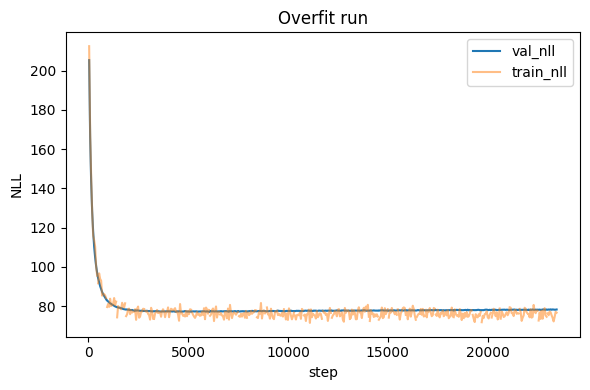

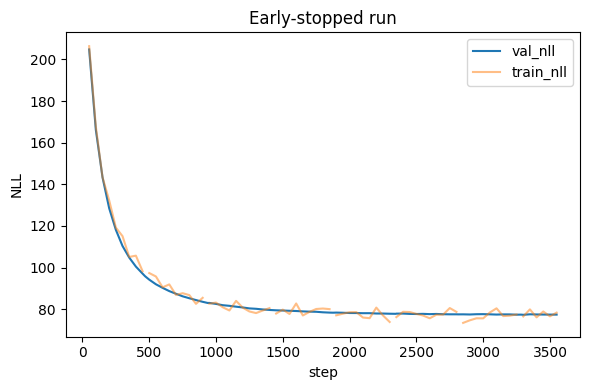

In [ ]:
#| echo: false
#| output: false
import pandas as pd

def plot_logs(logs, title):
    df = pd.DataFrame(logs)
    xs = df['step'].fillna(method='ffill').fillna(0)
    plt.figure(figsize=(6,4))
    plt.plot(xs, df['val_nll'], label='val_nll')
    if 'train_nll' in df:
        plt.plot(xs, df['train_nll'], label='train_nll', alpha=0.5)
    plt.title(title)
    plt.xlabel('step')
    plt.ylabel('NLL')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_logs(overfit_logs, 'Overfit run')
plot_logs(es_logs, 'Early-stopped run')


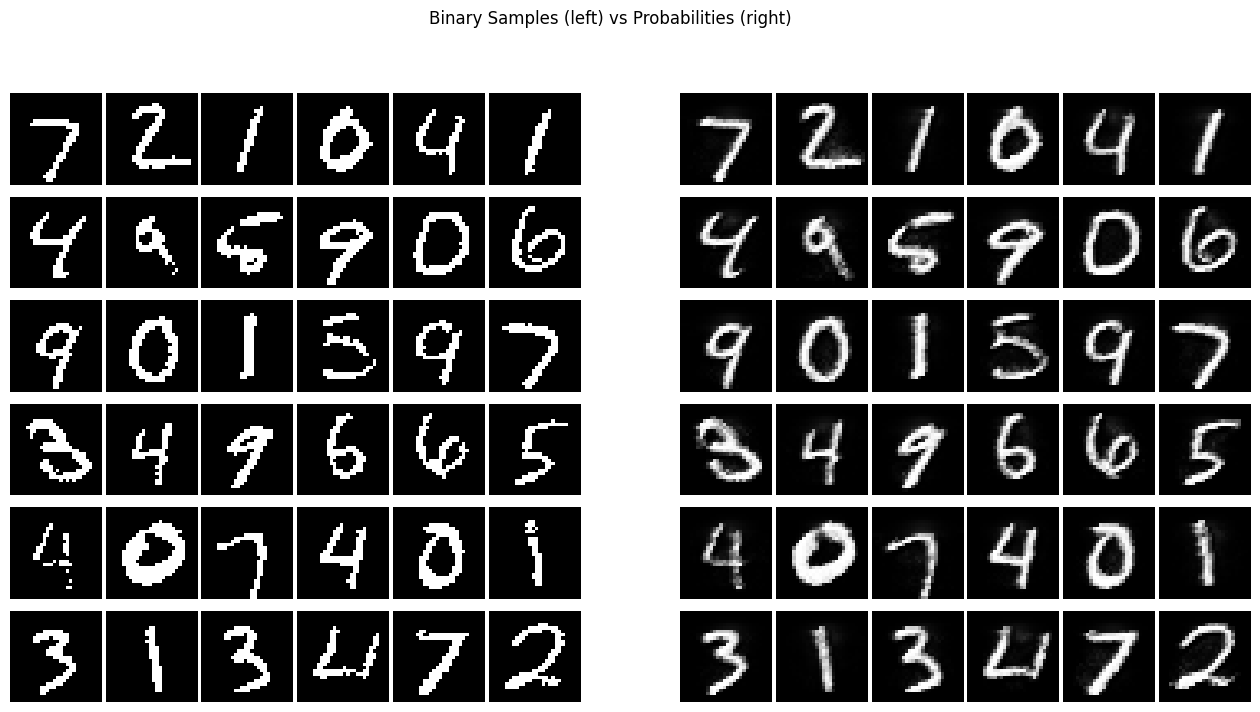

In [ ]:
#| echo: false
with torch.no_grad():
    m_es = AutoregressiveLogistic(D).to(device)
    m_es.load_state_dict(torch.load(es_ckpt)['model'])
    
    x_batch = next(iter(valloader_bin))[0][:36]
    x_batch_flat = x_batch.view(36, -1).to(device)
    s_es = (torch.sigmoid(m_es.logits(x_batch_flat)) > 0.5).float().view(36, 28, 28).cpu().numpy()
    probs_es = torch.sigmoid(m_es.logits(x_batch_flat)).view(36, 28, 28).cpu().numpy()

fig = plt.figure(figsize=(16, 8))

gs = fig.add_gridspec(6, 13, wspace=0.05, hspace=0.05)

for i in range(6):
    for j in range(6):
        idx = i * 6 + j
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(s_es[idx], cmap='gray')
        ax.axis('off')

for i in range(6):
    for j in range(6):
        idx = i * 6 + j
        ax = fig.add_subplot(gs[i, j+7])
        ax.imshow(probs_es[idx], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')

fig.suptitle('Binary Samples (left) vs Probabilities (right)')
plt.show()

It is interesting

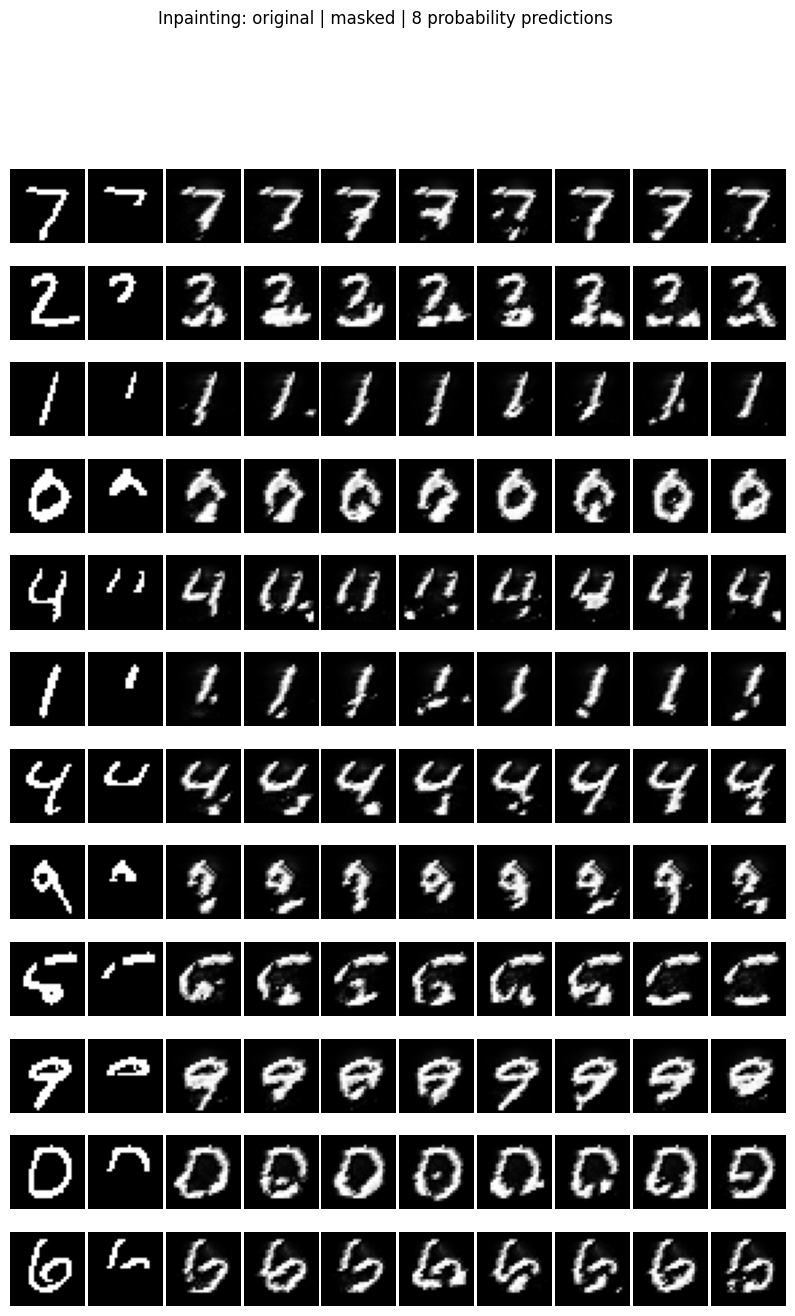

In [ ]:
#| echo: false
def inpaint_ancestral(model, x_obs, mask, sample=True, temperature=1.0):
    x = torch.zeros_like(x_obs)
    for i in range(x.size(1)):
        w_i = model.weight[i] * model.mask[i]
        logits_i = model.bias[i] + x @ w_i
        logits_i = logits_i / temperature
        probs_i = torch.sigmoid(logits_i)
        x_i = torch.bernoulli(probs_i) if sample else (probs_i > 0.5).float()
        x[:, i] = torch.where(mask[:, i].bool(), x_obs[:, i], x_i)
    return x

def make_bottom_mask(h, w):
    m = torch.ones(h, w, device=device)
    m[h//2:, :] = 0
    return m

with torch.no_grad():
    x_batch = next(iter(valloader_bin))[0][:12].to(device)
    x_flat = x_batch.view(12, -1)
    x_bin = binarize(x_flat)

    mask_img = make_bottom_mask(28, 28).view(1, -1)
    mask = mask_img.expand(12, -1)
    x_obs = x_bin * mask

    num_predictions = 8
    all_probs = []
    
    for _ in range(num_predictions):
        x_inpaint = inpaint_ancestral(m_es, x_obs, mask, sample=True, temperature=1.0)
        probs = torch.sigmoid(m_es.logits(x_inpaint)).view(-1, 28, 28).cpu().numpy()
        all_probs.append(probs)

    x_orig_img = x_bin.view(-1, 28, 28).cpu().numpy()
    x_masked_img = x_obs.view(-1, 28, 28).cpu().numpy()

fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(12, 10, wspace=0.05, hspace=0.05)
for i in range(12):
    ax = fig.add_subplot(gs[i, 0])
    ax.imshow(x_orig_img[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax = fig.add_subplot(gs[i, 1])
    ax.imshow(x_masked_img[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    for j in range(num_predictions):
        ax = fig.add_subplot(gs[i, j+2])
        ax.imshow(all_probs[j][i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
fig.suptitle('Inpainting: original | masked | 8 probability predictions')
plt.show()

## NADE

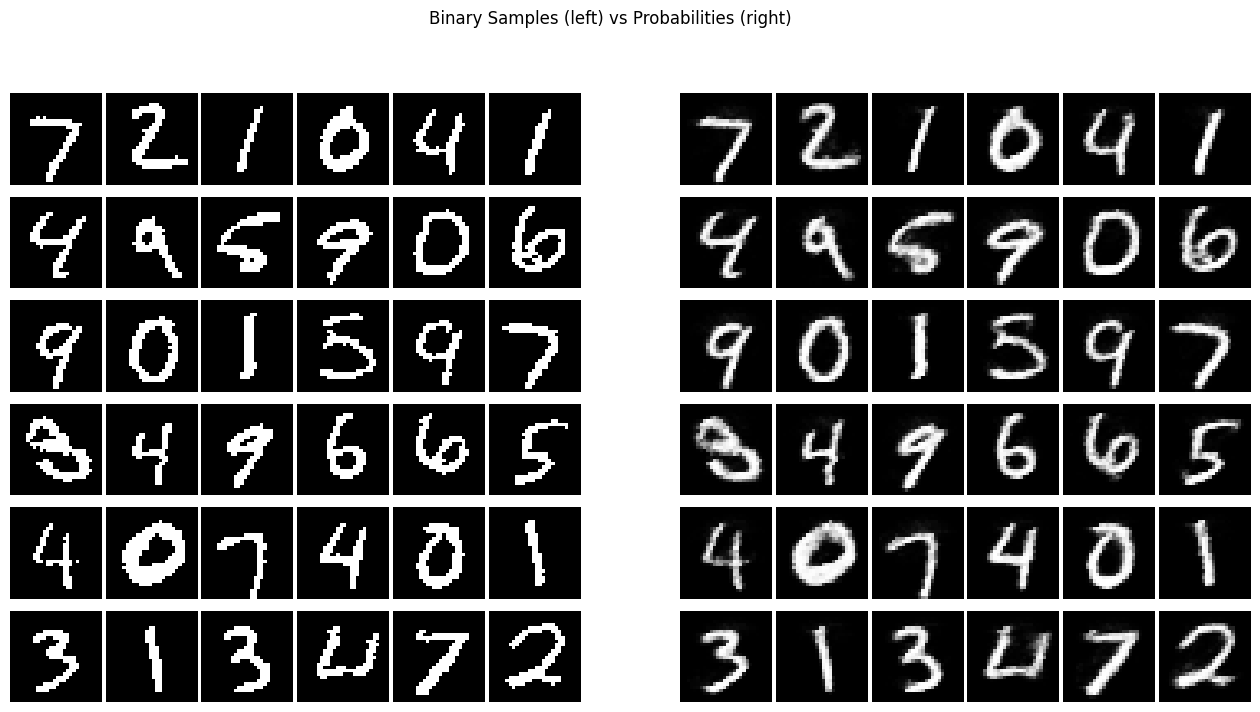

In [42]:
#| echo: false
with torch.no_grad():
    nade_es = NADE(D, H).to(device)
    nade_es.load_state_dict(torch.load(nade_ckpt)['model'])
    
    x_batch = next(iter(valloader_bin))[0][:36]
    x_batch_flat = x_batch.view(36, -1).to(device)
    s_es = (torch.sigmoid(nade_es.logits(x_batch_flat)) > 0.5).float().view(36, 28, 28).cpu().numpy()
    probs_es = torch.sigmoid(nade_es.logits(x_batch_flat)).view(36, 28, 28).cpu().numpy()

fig = plt.figure(figsize=(16, 8))

gs = fig.add_gridspec(6, 13, wspace=0.05, hspace=0.05)

for i in range(6):
    for j in range(6):
        idx = i * 6 + j
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(s_es[idx], cmap='gray')
        ax.axis('off')

for i in range(6):
    for j in range(6):
        idx = i * 6 + j
        ax = fig.add_subplot(gs[i, j+7])
        ax.imshow(probs_es[idx], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')

fig.suptitle('Binary Samples (left) vs Probabilities (right)')
plt.show()

## Limitations

What the autoregressive model cannot give us:

1. Get a representation of an image.

Some dense vector (dim significantly less then the image) we could use in other applications

2. Assess similarity of images (almost same as 1.)

Some function $f$ such that similarity would presumably be high for the same digits, but written differently and somewhat high for digits that are just written similarly to each other.

3. Discover some underlying structure in the data (e.g., clusters) (almost same as 1.)

For example, being able to tell what digit is on the image.

4. Guided generation.

Being able to generate image of a certain digit, or a digit of a certain style.
